
# 基于图神经网络的小批量图分类任务

参考：

包括本课程在内的多数pyg教程都来自官网的案例：

https://pytorch-geometric.readthedocs.io/en/latest/get_started/colabs.html

下面是中文翻译：

https://zhuanlan.zhihu.com/p/477339992


有趣的例子：

https://zhuanlan.zhihu.com/p/480831103



图分类 (Graph classification) 指的是对于已知的图数据集, 基于一些结构图的属性, 分类整张图的任务. 因此, 我们需要嵌入整张图, 并且使它们在某些任务下是线性可分的.


## TUDataset 数据集

图分类中, 最常见的任务是 分子性质预测 (molecular property prediction), 其中一个分子被表达成一张图. 举个例子, 任务可以是推断一个分子是否抑制HIV病毒的复制. 多特蒙德工业大学收集了广泛的图分类数据集, 取名为TUDatasets. 在PyG中, 我们可以通过 torch_geometric.datasets.TUDataset 来获取这个数据集. 

这个数据集提供 188张不同的图, 我们的任务是分类每张图到两个类别中的一个.

通过检查数据集的第一个图对象, 我们可以发现它有 17个节点 (每个节点有 7维的特征向量), 和 38条边 (平均节点出入度数 38/17=2.24), 每张图都有 一个图标签 y=[1]. 另外, 每条边还有额外的 4维边特征 (edge feature) edge_attr=[38, 4]. 但是, 为了让本教程足够简单, 我们不会使用这些额外特征.

PyG 提供一些便利函数来帮助我们更好地处理图数据集, 例如, 我们可以 洗牌 (shuffle) 数据集, 并使用前150个图作为训练集, 其余的用作测试:

In [16]:
import torch
from torch_geometric.datasets import TUDataset #分子数据集：https://chrsmrrs.github.io/datasets/
from torch_geometric.utils import to_networkx
import networkx as nx
import matplotlib.pyplot as plt

dataset = TUDataset(root='data/TUDataset', name='MUTAG')

print()
print(f'Dataset: {dataset}:')
print('====================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

data = dataset[0]  # Get the first graph object.

print()
print(data)
print('=============================================================')

# Gather some statistics about the first graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')


Dataset: MUTAG(188):
Number of graphs: 188
Number of features: 7
Number of classes: 2

Data(edge_index=[2, 38], x=[17, 7], edge_attr=[38, 4], y=[1])
Number of nodes: 17
Number of edges: 38
Average node degree: 2.24
Has isolated nodes: False
Has self-loops: False
Is undirected: True


In [21]:
for i in dataset:
    print(i.y)

tensor([1])
tensor([0])
tensor([0])
tensor([1])
tensor([0])
tensor([1])
tensor([0])
tensor([1])
tensor([0])
tensor([1])
tensor([1])
tensor([1])
tensor([1])
tensor([0])
tensor([1])
tensor([1])
tensor([0])
tensor([1])
tensor([0])
tensor([1])
tensor([1])
tensor([1])
tensor([1])
tensor([1])
tensor([1])
tensor([1])
tensor([1])
tensor([1])
tensor([1])
tensor([1])
tensor([1])
tensor([1])
tensor([1])
tensor([0])
tensor([1])
tensor([0])
tensor([1])
tensor([0])
tensor([0])
tensor([0])
tensor([1])
tensor([0])
tensor([1])
tensor([1])
tensor([1])
tensor([1])
tensor([1])
tensor([1])
tensor([1])
tensor([1])
tensor([1])
tensor([1])
tensor([1])
tensor([1])
tensor([0])
tensor([1])
tensor([1])
tensor([1])
tensor([1])
tensor([1])
tensor([1])
tensor([0])
tensor([1])
tensor([1])
tensor([0])
tensor([0])
tensor([1])
tensor([1])
tensor([1])
tensor([0])
tensor([1])
tensor([1])
tensor([0])
tensor([1])
tensor([1])
tensor([0])
tensor([0])
tensor([0])
tensor([1])
tensor([1])
tensor([1])
tensor([1])
tensor([1])
tens

In [10]:
dataset[1]

Data(edge_index=[2, 20], x=[10, 7], edge_attr=[20, 4], y=[1])

### 图可视化

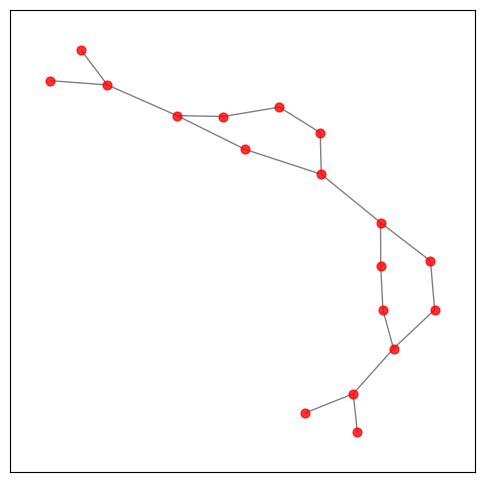

In [27]:
TUNet=to_networkx(dataset[20]) # type : networkx.classes.graph.Graph
TUNet=TUNet.to_undirected() # 转化为无向图
pos=nx.spring_layout(TUNet) # 网络图中节点的布局方式
plt.figure(figsize=(6,6))
nx.draw_networkx_nodes(TUNet,pos,node_size=40,node_color="red",alpha=0.8)
nx.draw_networkx_edges(TUNet,pos,width=1,edge_color="gray")
plt.show()

### 数据集的划分

In [3]:
torch.manual_seed(12345)
dataset = dataset.shuffle()

train_dataset = dataset[:150]
test_dataset = dataset[150:]

print(f'Number of training graphs: {len(train_dataset)}')
print(f'Number of test graphs: {len(test_dataset)}')

Number of training graphs: 150
Number of test graphs: 38


## 图的小批量 (mini-batching) 训练

既然在图分类数据集中的单张图都比较小, 我们可以在输入到 GNN 之前, 将这些图 "捆" 成多个批次进行训练, 这样可以保证充分 GPU 的利用率. 在图像或语言领域, 这一过程通常通过将每个样例 缩放 (rescaling) 或 填充 (padding) 为一组形状相等的数据来实现 (这样输入数据就多了一个额外的维度). 这个维度的长度等于在小批量中的样本个数, 我们通常称其为 batch_size.

但是, 对于GNN来说, 上述的两种方法都不可行, 或者说可能会导致不必要的内存消耗. 因此, PyG使用另一种方法优化, 以取得高效的样本之间的并行. 在本例中, 邻接矩阵 (adjacency matrix) 以对角阵的形式堆积, 也就是多个子图构建一个大图. 在节点维度里, 节点和其特征会 拼接 (concatenate) 在一起, 从而形成大图的节点信息:

此程序与其他批处理程序相比有一些关键的优点:

1.依赖于消息传递架构的GNN操作器不需要额外的修改. 这是因为不同图的节点之间不会进行消息交换.

2. 没有计算或内存开销, 因为邻接矩阵是 稀疏的 (sparse), 也就是它只会保存非零的值, 也就是有连接的边.

通过 torch_geometric.data.DataLoader 类, PyG会自动地处理, 构建多个子图成一个批量的大图.

这里我们使用64的 batch_size, 这样我们会有3个小批量, 也就是包含 2 * 64 + 22 = 150 张图. 另外, 每个Batch对象都配有一个 赋值向量 (assignment vector) batch, 这个向量映射每个节点到它对应的批量里的图

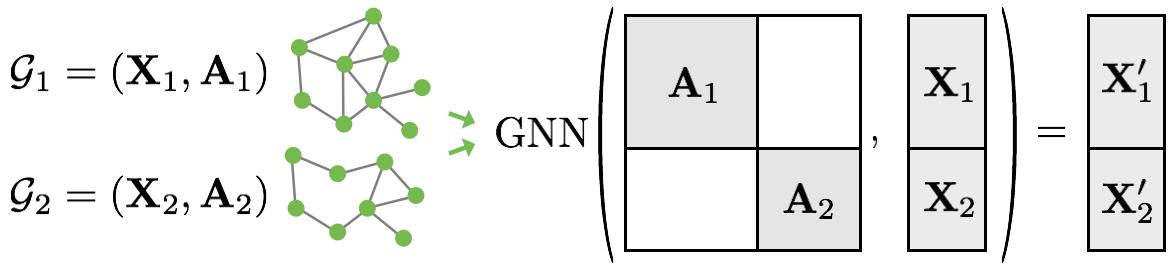

In [7]:
from torch_geometric.loader import DataLoader

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

for step, data in enumerate(train_loader):
    print(f'Step {step + 1}:')
    print('=======')
    print(f'Number of graphs in the current batch: {data.num_graphs}')
    print(data)
    print()

Step 1:
Number of graphs in the current batch: 64
DataBatch(edge_index=[2, 2540], x=[1141, 7], edge_attr=[2540, 4], y=[64], batch=[1141], ptr=[65])

Step 2:
Number of graphs in the current batch: 64
DataBatch(edge_index=[2, 2542], x=[1154, 7], edge_attr=[2542, 4], y=[64], batch=[1154], ptr=[65])

Step 3:
Number of graphs in the current batch: 22
DataBatch(edge_index=[2, 912], x=[419, 7], edge_attr=[912, 4], y=[22], batch=[419], ptr=[23])



现在对188个图，做成了3个batch

### 训练 GNN

要训练一个GNN来进行图分类, 我们通常需要以下步骤:

1.通过执行多轮消息传递来嵌入每个节点

2.聚集 (aggregate) 节点嵌入 (node embedding) 到一个统一的 图嵌入 (graph embedding), 也就是读出层 (readout layer)

3.基于图嵌入来训练最终的分类器

文献中已有很多不同的 读出层, 但是最常用的只是简单地利用了节点嵌入的优势:


PyG也同样提供这一读出层 torch_geometric.nn.global_mean_pool, 该函数的输入为小批量内所有节点的节点嵌入和 赋值向量 batch 来为批量内的每张图计算图嵌入 (形状为 [batch_size, hidden_channels]). 将GNN应用于图分类任务的最终架构如下所示:

$$
\mathbf{x}_{\mathcal{G}} = \frac{1}{|\mathcal{V}|} \sum_{v \in \mathcal{V}} \mathcal{x}^{(L)}_v
$$


In [5]:
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool


class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GCN, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GCNConv(dataset.num_node_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.lin = Linear(hidden_channels, dataset.num_classes)

    def forward(self, x, edge_index, batch):
        # 1.对各节点进行编码
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.conv3(x, edge_index)

        # 2. 平均操作
        x = global_mean_pool(x, batch)  # [batch_size, hidden_channels]

        # 3. 输出
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)
        
        return x

model = GCN(hidden_channels=64)
print(model)

GCN(
  (conv1): GCNConv(7, 64)
  (conv2): GCNConv(64, 64)
  (conv3): GCNConv(64, 64)
  (lin): Linear(in_features=64, out_features=2, bias=True)
)


In [9]:
model = GCN(hidden_channels=64)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

def train():
    model.train()

    for data in train_loader:  # Iterate in batches over the training dataset.
        out = model(data.x, data.edge_index, data.batch)  # Perform a single forward pass.
        loss = criterion(out, data.y)  # Compute the loss.
        loss.backward()  # Derive gradients.
        optimizer.step()  # Update parameters based on gradients.
        optimizer.zero_grad()  # Clear gradients.

def test(loader):
    model.eval()

    correct = 0
    for data in loader:  # Iterate in batches over the training/test dataset.
        out = model(data.x, data.edge_index, data.batch)  
        pred = out.argmax(dim=1)  # Use the class with highest probability.
        correct += int((pred == data.y).sum())  # Check against ground-truth labels.
    return correct / len(loader.dataset)  # Derive ratio of correct predictions.


for epoch in range(1, 171):
    train()
    train_acc = test(train_loader)
    test_acc = test(test_loader)
    print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')

Epoch: 001, Train Acc: 0.6467, Test Acc: 0.7368
Epoch: 002, Train Acc: 0.6467, Test Acc: 0.7368
Epoch: 003, Train Acc: 0.6467, Test Acc: 0.7368
Epoch: 004, Train Acc: 0.6467, Test Acc: 0.7368
Epoch: 005, Train Acc: 0.6467, Test Acc: 0.7368
Epoch: 006, Train Acc: 0.6533, Test Acc: 0.7368
Epoch: 007, Train Acc: 0.7467, Test Acc: 0.7632
Epoch: 008, Train Acc: 0.7267, Test Acc: 0.7632
Epoch: 009, Train Acc: 0.7200, Test Acc: 0.7632
Epoch: 010, Train Acc: 0.7133, Test Acc: 0.7895
Epoch: 011, Train Acc: 0.7200, Test Acc: 0.7632
Epoch: 012, Train Acc: 0.7200, Test Acc: 0.7895
Epoch: 013, Train Acc: 0.7200, Test Acc: 0.7895
Epoch: 014, Train Acc: 0.7133, Test Acc: 0.8421
Epoch: 015, Train Acc: 0.7133, Test Acc: 0.8421
Epoch: 016, Train Acc: 0.7533, Test Acc: 0.7368
Epoch: 017, Train Acc: 0.7400, Test Acc: 0.7632
Epoch: 018, Train Acc: 0.7133, Test Acc: 0.8421
Epoch: 019, Train Acc: 0.7400, Test Acc: 0.7895
Epoch: 020, Train Acc: 0.7533, Test Acc: 0.7368
Epoch: 021, Train Acc: 0.7467, Test Acc: